In [1]:
import cv2
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision import models


# 对比展示原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    plt.figure()
    # 归一化
    if original_img.any()>1.0:
        original_img=original_img/255.0
    if adversarial_img.any()>1.0:
        adversarial_img=adversarial_img/255.0
    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')
    plt.subplot(132)
    plt.title(adversarial_img)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')
    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference=adversarial_img-original_img
    # (-1,1)->(1,0)
    difference=difference/abs(difference).max()/2.0 +0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#图像加载以及预处理
image_path="../picture/cow.jpeg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img=orig.copy().astype(np.float32)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img=(img-mean)/std
img=img.transpose(2,0,1)
img=np.expand_dims(img,axis=0)
print(img.shape)
model=models.alexnet(pretrained=True).to(device).eval()

TypeError: 'NoneType' object is not subscriptable

In [6]:
max_iterations=1000 # 1000次可以完成95%的优化工作
learning_rate=0.01
binary_search_steps=10 #二分查找最大迭代次数
initial_const=1e2  # c的初始值
confidence=initial_cost
k=40 # k值
# 像素值区间
boxmin = -3.0
boxmax = 3.0
num_labels=1000 # 类别数
# 攻击目标标签，必须使用one hot编码
target_label = 288
tlab=Variable(torch.from_numpy(np.eye(num_labels)[target_label]).to(device).float())
# np.eye 生成对角矩阵
shape=(1,3,224,224)

In [ ]:
# c的初始化边界
lower_bound=0
c=initial_const
upper_bound=1e10
# the best l2, score, and image attack
o_bestl2=1e10
o_bestscore=-1
o_bestattack=[np.zeros(shape)]
# the resulting image, tanh'd to keep bound from boxmin to boxmax
boxmul=(boxmax-boxmin)/2.0
boxplus=(boxmin+boxmax)/2.0

for outer_step in range(binary_search_steps):
    print("o_bestl2={} confidence={}".format(o_bestl2,confidence))
    # 把原始图像转换成图像数据和扰动的形态
    timg=Variable(torch.from_numpy(np.arctanh((img-boxplus)/boxmul*0.99999)).to(device).float())
    modifier=Variable(torch.zeros_like(timg).to(device).float())
    # 图像数据的扰动量梯度可以获取
    modifier.requires_grad = True
    optimizer=torch.optim.Adam([modifier],lr=learning_rate) # 优化器
    for iteration in range(1,max_iterations+1):
        optimizer.zero_grad()
        # 定义新输入
        newimg=torch.tanh(modifier+timg)*boxmul+boxplus
        output=model(newimg)
        # 定义cw中的损失函数  l2范数
        loss2=torch.dist(newimg,(torch.tanh(timg)*boxmul+boxplus),p=2)
        real= torch.max(output*tlab)
        other=torch.max((1-tlab)*output)
        loss1=other-real+k
        loss1=torch.clamp(loss1,min=0) # 限制范围，截取功能
        loss1=confidence*loss1
        loss=loss1+loss2
        loss.backward(retain_graph=True)
        optimizer.step()
        l2=loss2
        sc=output.data.cpu().numpy()
        # 显示
        if(iteration%(max_iterations//10)==0):
            print("iteration={} loss={} loss1={} loss2={}".format(
            iteration,loss,loss1,loss2))
        if(l2<o_bestl2)and(np.argmax(sc)==target_label):
            print('attack success l2={} target_label={}'.format(l2,target_label))
            o_bestl2=l2
            o_bestscore=np.argmax(sc)
            o_bestattack=newimg.data.cpu().numpy()
    confidence_old=-1
    if(o_bestscore==target_label)and o_bestscore!=-1:
        # 攻击成功，减小c
        upper_bound=min(upper_bound,confidence)
        if upper_bound<1e9:
            print()
            confidence_old=confidence
            confidence=(lower_bound+upper_bound)/2
    else:
        lower_bound=max(lower_bound,confidence)
        confidence_old=confidence
        if upper_bound<1e9:
            confidence=(lower_bound+upper_bound)/2
        else:
            confidence *=10
    print("outer_step={} confidence {}->{}".format(outer_step,
                                                  confidence_old,confidence))

In [9]:
print(o_bestattack.shape)
print(img.shape)

(1, 3, 224, 224)
(1, 3, 224, 224)


(3, 224, 224)


/home/yanhuanqian/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


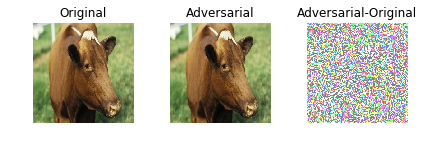

In [12]:
adv=o_bestattack[0]
print(adv.shape)
adv=adv.transpose(1,2,0)
adv=(adv*std)+mean
adv=adv*255.0
adv=np.clip(adv,0,255).astype(np.uint8)
show_images_diff(orig,0,adv,0)